# 2022 Summer Workshop Series
## A Deep Dive in Data Analysis

We should be asking these overarching questions of ourselves:
- What format problems do we have?
- Where do we trust the data?
- Where don't we trust the data?
- WHY??
- Given these constraints, what can we do?

In [3]:
## Import Libraries
import os
import pandas as pd
import numpy as np
import geojson
import opendatasets as od
import matplotlib.pyplot as plt
import folium
import seaborn as sns

#For Jupyter Notebooks only
%matplotlib inline

In [2]:
## Set working directory
## Note on Data Pipelines:
##    Here we are manually connecting to files on a computer, often we have to encode everything in digital pipelines 
##    in the cloud, which has its own headaches.
os.chdir('C:/Users/JakeHightower/Desktop/SummerWorkshop2022')
print("Current Working Directory " , os.getcwd())


Current Working Directory  C:\Users\JakeHightower\Desktop\SummerWorkshop2022


In [3]:
####-------------------------------------------------------------------------------------------------------------------#
## Download Covid19 Data Set
#Note: you'll need a username & to download a key (can open JSON with text file/ screengrab)
#dataset_url = 'https://www.kaggle.com/sudalairajkumar/covid19-in-usa'
#od.download(dataset_url)

In [4]:
## Open Covid19 Data Set
c19 = pd.read_csv("covid19-in-usa/us_counties_covid19_daily.csv")

### Data Cleaning

In [5]:
## Data Cleaning

## Do you know what the data SHOULD look like? Compare that to the quick dive here:
print(c19.dtypes)         # Notice that cases and deaths are not stored as the same data type
print(c19.describe()  )   # Notice the maxes of Cases and Deaths?! Will need to look into this
print(c19.shape)       
print('No. of rows: %s |  No. of cols: %s' % (c19.shape[0], c19.shape[1]))

## 800k rows, but how many are distinct days?
unique_dates = c19['date'].nunique()
print('\nUnique Dates: %s' % (unique_dates)) #320
print('Start Date: %s' % (c19['date'].min()))
print('End Date: %s' % (c19['date'].max()))

## Note: Very common in timeseries data to have missing dates (not null/ nan/ or 0, but MISSING).
##       Need to confirm your index is complete.

##  How many distinct counties/ states? 
print('\nUnique Counties: %s' % (c19['county'].nunique()))   # 1929, but there are 3,006 in the US. What's missing?
print('\nTotal States: %s' % (c19['state'].nunique()) )      # 55 states? List
      
## Confirm if 55 states == states & territories
c19_states = list(c19['state'].unique())
print(len(c19_states))
print('\n',c19_states) #DC, Guam, N Mariana Islands, Puerto Rico, Virgin Islands (so States & Territories) --> should we update col name to reflect?)


date       object
county     object
state      object
fips      float64
cases       int64
deaths    float64
dtype: object
                fips          cases         deaths
count  792846.000000  800437.000000  783704.000000
mean    31238.198828    1589.667358      48.815309
std     16289.192418    8385.201329     440.482993
min      1001.000000       0.000000       0.000000
25%     18179.000000      29.000000       0.000000
50%     29209.000000     175.000000       3.000000
75%     46097.000000     775.000000      17.000000
max     78030.000000  439538.000000   24346.000000
(800437, 6)
No. of rows: 800437 |  No. of cols: 6

Unique Dates: 320
Start Date: 2020-01-21
End Date: 2020-12-05

Unique Counties: 1929

Total States: 55
55

 ['Washington', 'Illinois', 'California', 'Arizona', 'Massachusetts', 'Wisconsin', 'Texas', 'Nebraska', 'Utah', 'Oregon', 'Florida', 'New York', 'Rhode Island', 'Georgia', 'New Hampshire', 'North Carolina', 'New Jersey', 'Colorado', 'Maryland', 'Nevada', 'Tenne

In [6]:
## Nan/Null & Missing Assessment
print('Percent Missing: ')
for col in c19.columns:
    pct_missing = np.mean(c19[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))


c19_nan = c19.loc[c19.isnull().any(axis=1)]
print(c19_nan.head())

Percent Missing: 
date - 0%
county - 0%
state - 0%
fips - 1%
cases - 0%
deaths - 2%
           date         county         state  fips  cases  deaths
416  2020-03-01  New York City      New York   NaN      1     0.0
418  2020-03-01        Unknown  Rhode Island   NaN      2     0.0
448  2020-03-02  New York City      New York   NaN      1     0.0
450  2020-03-02        Unknown  Rhode Island   NaN      2     0.0
482  2020-03-03  New York City      New York   NaN      2     0.0


<AxesSubplot:>

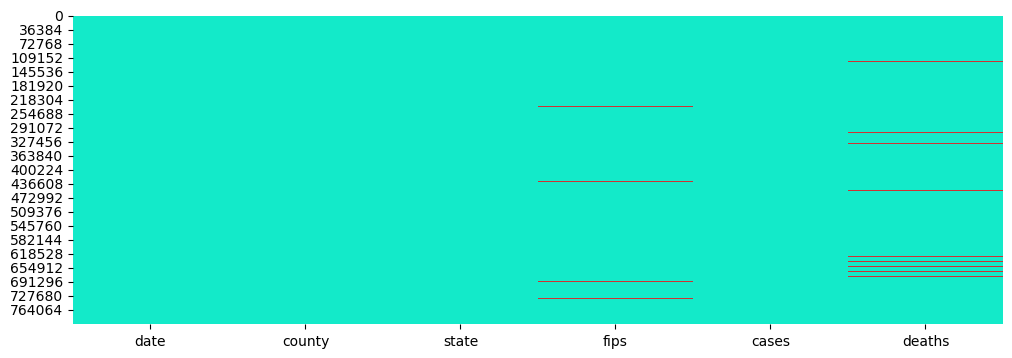

In [7]:
## Where are there missings- is there autocorrelation? (Note: visualizing not viable for most datasets, too large)
figs, axs = plt.subplots(figsize=(12,4))
colours = ['#13EAC9', '#CD3333']
sns.heatmap(c19.isnull(), cmap=sns.color_palette(colours), cbar=False)

In [ ]:
## Check for duplicates ###################################################################################
## Pseudocode to check all below
#dupes = []
#for s in states:
#    for c in counties:
#        create new df
#        ise_dupe = check for dupes
#        dupes.append(is_dupe)

In [8]:
# Focus on one state/ county below as example:
FL_orange = c19[(c19.state == 'Florida') & (c19.county == 'Orange')]
for col in FL_orange.columns:
    pct_dupe = np.mean(FL_orange[col].duplicated())
    print('{} - {}%'.format(col, round(pct_dupe*100)))

date - 0%
county - 100%
state - 100%
fips - 100%
cases - 1%
deaths - 42%


### Reformat Data/ Create View

cases       int64
deaths    float64
dtype: object
            cases  deaths
date                     
2020-01-21      1     0.0
2020-01-22      1     0.0
2020-01-23      1     0.0
2020-01-24      2     0.0
2020-01-25      3     0.0


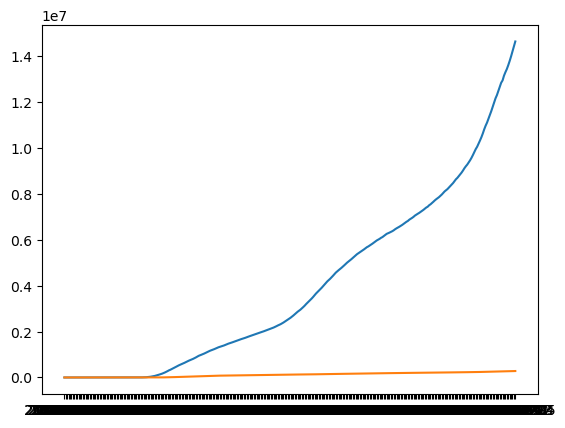

In [9]:
## Format Data as true timeseries, where index is UNIQUE date.
## Here we will look at the entire US, but should do this by state and by county
c19_daily = c19.groupby(['date']).sum()
c19_daily.drop('fips', axis=1, inplace=True)
print(c19_daily.dtypes) #notice cases are int and deaths are float- fyi, as a data scientist, my intution is there are probably NAs present in deaths which change the format
print(c19_daily.head())

plt.plot(c19_daily)

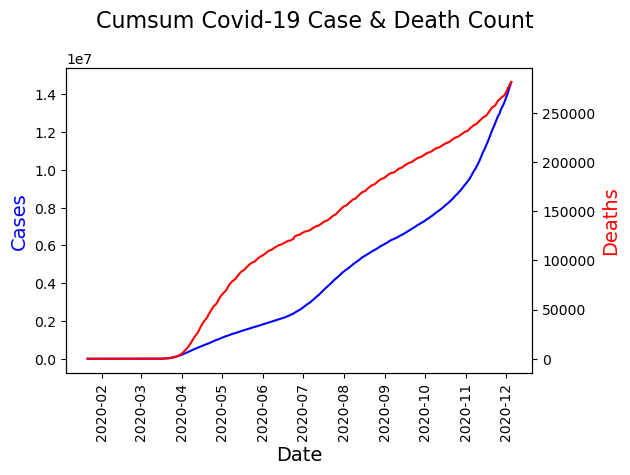

In [10]:
## Clean up data for legible graphs & analysis
## Axis is illegible because index is not stored as datetime
c19_daily.index = pd.to_datetime(c19_daily.index)

## Plot Cumsum Cases/ Deaths
# Create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(c19_daily['cases'],
        color="blue")
# set x-axis label
ax.set_xlabel("Date", fontsize = 14)
# set y-axis label
ax.set_ylabel("Cases",
              color="blue",
              fontsize=14)
ax.tick_params(axis='x',rotation=90)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(c19_daily['deaths'],
         color="red")
ax2.set_ylabel("Deaths",
               color="red",
               fontsize=14)
ax2.tick_params(axis='x',rotation=90)
fig.suptitle('Cumsum Covid-19 Case & Death Count', fontsize=16)
plt.tight_layout()
plt.show()

            cases_cumsum  deaths_cumsum  cases_daily  deaths_daily
date                                                              
2020-01-21             1            0.0          1.0           0.0
2020-01-22             1            0.0          0.0           0.0
2020-01-23             1            0.0          0.0           0.0
2020-01-24             2            0.0          1.0           0.0
2020-01-25             3            0.0          1.0           0.0


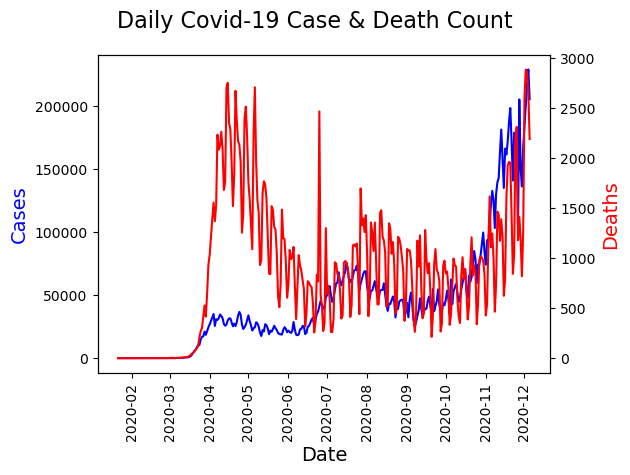

In [11]:
####-------------------------------------------------------------------------------------------------------------------#
## Convert Cumsum to daily
## Plot Daily Cases and Deaths
c19_daily.rename(columns={'cases': 'cases_cumsum', 'deaths': 'deaths_cumsum'}, inplace=True)
c19_daily['cases_daily'] = c19_daily['cases_cumsum'].diff().fillna(c19_daily['cases_cumsum'])
c19_daily['deaths_daily'] = c19_daily['deaths_cumsum'].diff().fillna(c19_daily['deaths_cumsum'])
print(c19_daily.head())

## Plot Daily Cases/ Deaths
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(c19_daily['cases_daily'],
        color="blue")
# set x-axis label
ax.set_xlabel("Date", fontsize = 14)
# set y-axis label
ax.set_ylabel("Cases",
              color="blue",
              fontsize=14)
ax.tick_params(axis='x',rotation=90)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(c19_daily['deaths_daily'],
         color="red")
ax2.set_ylabel("Deaths",
               color="red",
               fontsize=14)
ax2.tick_params(axis='x',rotation=90)
fig.suptitle('Daily Covid-19 Case & Death Count', fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
####-------------------------------------------------------------------------------------------------------------------#
## Check for missing dates (not empty, MISSING)
min_date = c19_daily.index.min()
max_date = c19_daily.index.max()

## Set timestamp as index

idx = pd.date_range(str(min_date), str(max_date))
print("Dates in dataframe: %s  vs Expected Length: %s " % (len(c19_daily), len(idx)))

Dates in dataframe: 320  vs Expected Length: 320 


In [ ]:
##Uncomment below to fix missing dates in index using "Reindex" Strategy
#c19_daily.set_index('new_dates', inplace=True)
#c19_daily = c19_daily.reindex(idx, fill_value=0)
#c19_daily.head()

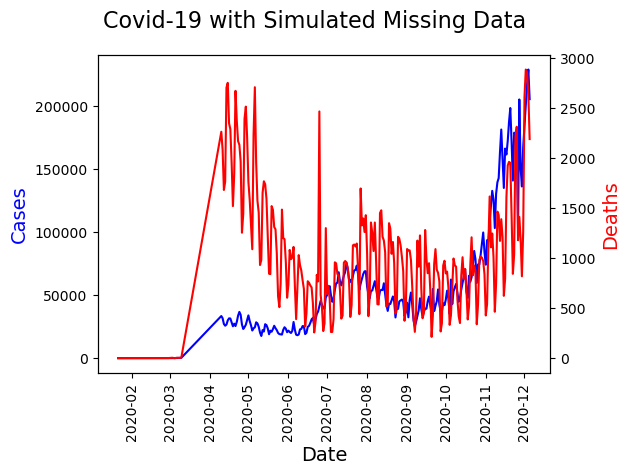

In [13]:
## Simulate example where dataset had missing data and you didn't know
## Note: Here I have simulated missing an entire MONTHs worth of dates, but usually missings will be haphazardously 
##       spread throughout your dataset. Exaggeration here to demonstrate issue.
c19_missings = c19_daily.copy()
c19_missings.drop(c19_missings.index[50:80], inplace=True)


## Plot
fig,ax = plt.subplots()
ax.plot(c19_missings['cases_daily'],
        color="blue")
ax.set_xlabel("Date", fontsize = 14)
ax.set_ylabel("Cases",
              color="blue",
              fontsize=14)
ax.tick_params(axis='x',rotation=90)
ax2=ax.twinx()
ax2.plot(c19_missings['deaths_daily'],
         color="red")
ax2.set_ylabel("Deaths",
               color="red",
               fontsize=14)
ax2.tick_params(axis='x',rotation=90)
fig.suptitle('Covid-19 with Simulated Missing Data', fontsize=16)
plt.tight_layout()
plt.show()


## Last Note: 
##    This dataset, formatted correctly, has the Index as a 'datetime' object. This is very usesful for timeseries analysis.
##    Very rarely will your data already come in this format. When it isn't, it often defaults to an object or string.
##    In which case, when we go to graph data that has MISSING indexes, those dates just wouldn't appear.
##    
##    Example
##      When not formatted correctly, if you are missing, for example, Tuesday in a week, it just won't exist. Eg. the graph
##      will read Mon-Wed-Thurs-Friday-Sat-Sun and continue. 

### Bias Assessment

<AxesSubplot:xlabel='date'>

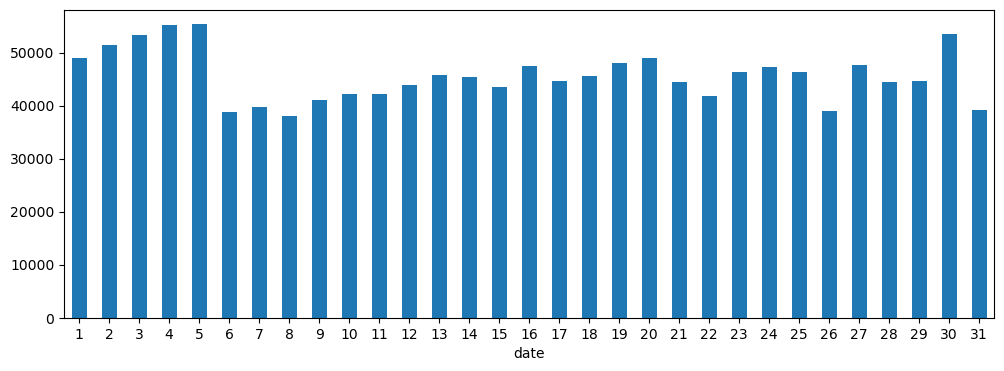

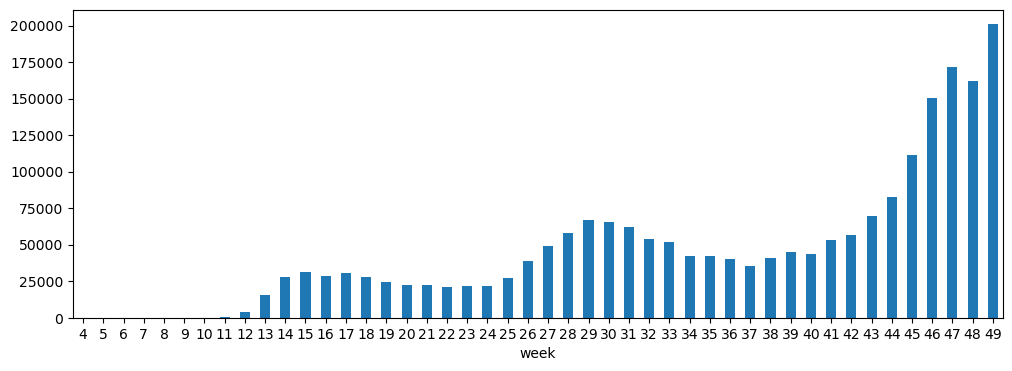

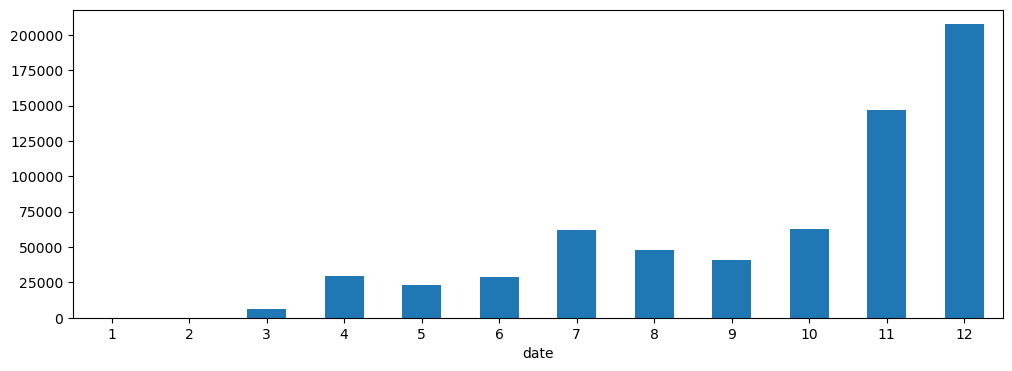

In [14]:
####-------------------------------------------------------------------------------------------------------------------#

## Daily Average
fig, axs = plt.subplots(figsize=(12, 4))
c19_daily.groupby(c19_daily.index.day)["cases_daily"].mean().plot(
    kind='bar', rot=0, ax=axs)
## Weekly Average
fig, axs = plt.subplots(figsize=(12, 4))
c19_daily.groupby(c19_daily.index.isocalendar().week)["cases_daily"].mean().plot(
    kind='bar', rot=0, ax=axs)
## Monthly Average
fig, axs = plt.subplots(figsize=(12, 4))
c19_daily.groupby(c19_daily.index.month)["cases_daily"].mean().plot(
    kind='bar', rot=0, ax=axs)

Text(0, 0.5, 'Cases')

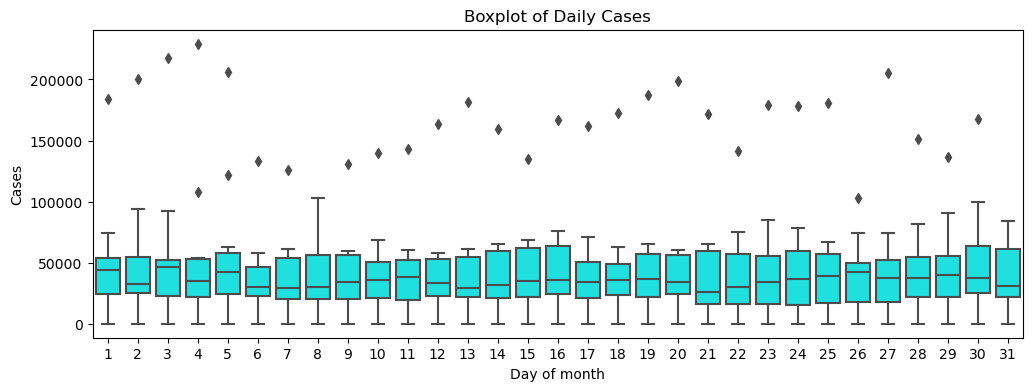

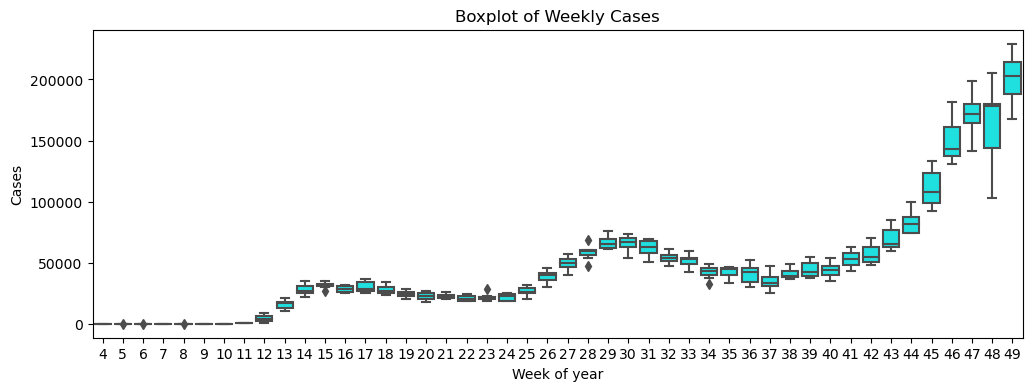

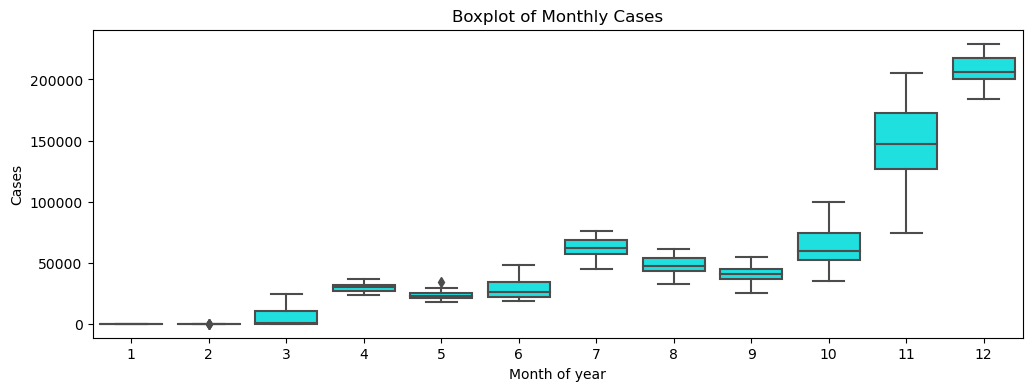

In [15]:
#------------------------------
# Daily cases with boxplot
fig, axs = plt.subplots(figsize=(12, 4))
sns.boxplot(x=c19_daily.index.day, y=c19_daily['cases_daily'], color = 'cyan')
axs.set_xlabel('Day of month')
axs.set_title('Boxplot of Daily Cases')
axs.set_ylabel('Cases')

# Weekly cases with boxplot
fig, axs = plt.subplots(figsize=(12, 4))
sns.boxplot(x=c19_daily.index.isocalendar().week, y=c19_daily['cases_daily'], color = 'cyan')
axs.set_xlabel('Week of year')
axs.set_title('Boxplot of Weekly Cases')
axs.set_ylabel('Cases')

# Monthly cases with boxplot
fig, axs = plt.subplots(figsize=(12, 4))
sns.boxplot(x=c19_daily.index.month, y=c19_daily['cases_daily'], color = 'cyan')
axs.set_xlabel('Month of year')
axs.set_title('Boxplot of Monthly Cases')
axs.set_ylabel('Cases')

### Correlation

array([[<AxesSubplot:xlabel='fips', ylabel='fips'>,
        <AxesSubplot:xlabel='cases', ylabel='fips'>,
        <AxesSubplot:xlabel='deaths', ylabel='fips'>],
       [<AxesSubplot:xlabel='fips', ylabel='cases'>,
        <AxesSubplot:xlabel='cases', ylabel='cases'>,
        <AxesSubplot:xlabel='deaths', ylabel='cases'>],
       [<AxesSubplot:xlabel='fips', ylabel='deaths'>,
        <AxesSubplot:xlabel='cases', ylabel='deaths'>,
        <AxesSubplot:xlabel='deaths', ylabel='deaths'>]], dtype=object)

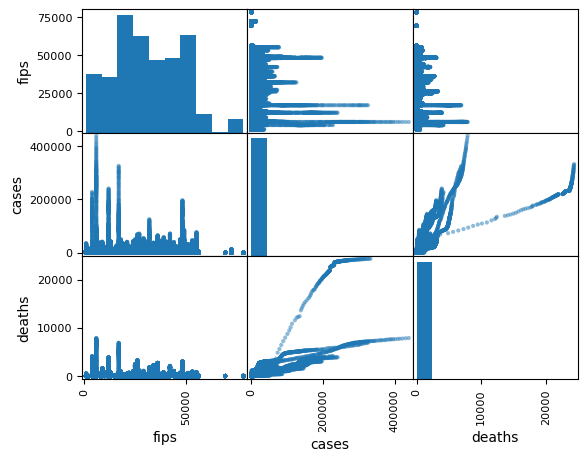

In [16]:
## Scatterplot matrix plots all variables against each other as x, y pair for correlation assessment
pd.plotting.scatter_matrix(c19)

## The diagonal shows the distribution (histogram) of the three numeric variables of our example data.
## Other cells are correlation plots of each variable combination in our dataframe.

Text(0.5, 0.98, 'Scatterplot: Fips vs. Case Count')

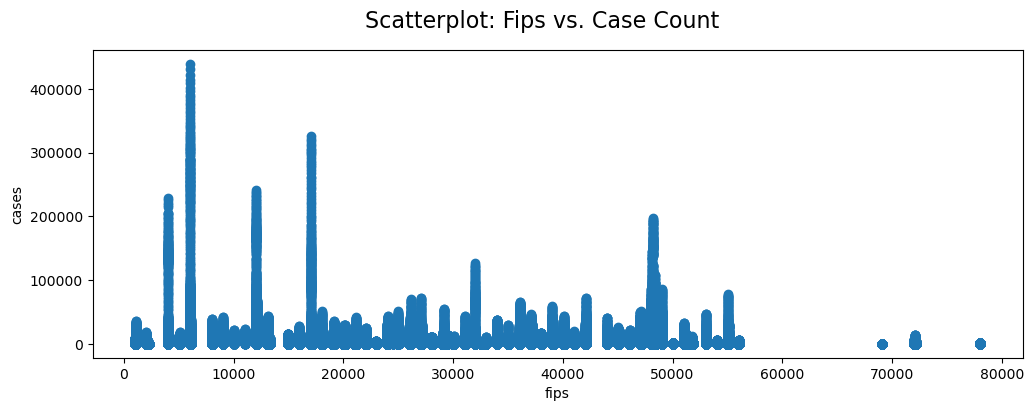

In [17]:
## Zoomed in example
## Note that I rotated/ flipped the axes as compared to the graph above
fig, axs = plt.subplots(figsize=(12, 4))
plt.scatter(c19['fips'],c19['cases'] )
plt.xlabel("fips")
plt.ylabel("cases")
fig.suptitle('Scatterplot: Fips vs. Case Count', fontsize=16)

<AxesSubplot:>

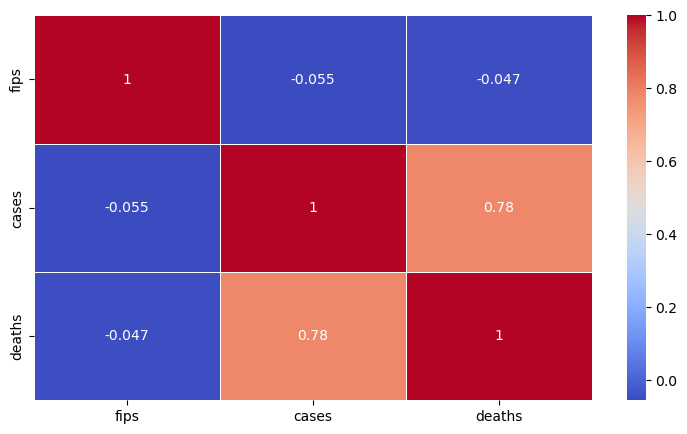

In [18]:
## Can get fun with heatmaps of correlations
plt.figure(figsize=(9,5))
sns.heatmap(c19.corr(), cmap = 'coolwarm', annot=True, linewidth = 0.5)

### Autocorrelation & Spatial Mapping

In [19]:
#Follow this link to download a data sample with latitude and longitude into your working directory:
#https://github.com/kjhealy/us-county/blob/master/data/geojson/gz_2010_us_050_00_500k.json

## Import GeoJson data (like JSON, but has specific latitude/longitude components used for visualization)
with open("gz_2010_us_050_00_500k.json") as f:
    geoj = geojson.load(f)
geo_usa = geoj['features'][0]

In [20]:
m = folium.Map(location=[40, -95], zoom_start=4)
m

In [21]:
## Create example dataset to map
mapp = c19.copy()
mapp = mapp.groupby(['county']).sum()
mapp.reset_index(inplace=True)
print(mapp.head())

      county        fips    cases   deaths
0  Abbeville  11790262.0    89140   1853.0
1     Acadia   5698259.0   470146  15640.0
2   Accomack  13311261.0   235243   3556.0
3        Ada   4288268.0  2148289  22346.0
4      Adair  27884023.0   262505   6545.0


In [22]:
folium.Choropleth(geo_data = geo_usa,
                  name = "Choropleth",
                  data = mapp,
                  columns = ['county', 'cases'],
                  key_on = 'feature.properties.COUNTY',
                  fill_color = "YlGn",
                  fill_opacity=0.7,
                  line_opacity=0.1,
                  legend_name = "Cases").add_to(m)

folium.LayerControl().add_to(m)

m


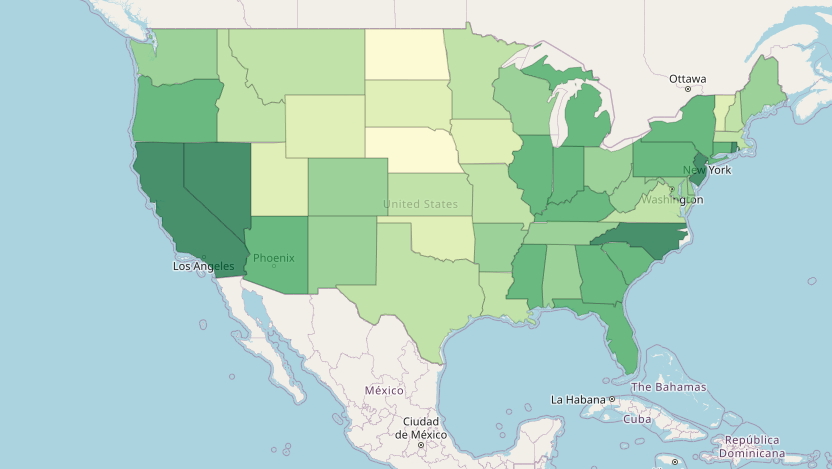

In [ ]:
## Typical Mapping Issues
# Projections (WGS84, ...)
# Latitude/Longitude Format
# Data Table Merging Issues (e.g. Orange County vs ORANGE COUNTY)
# Duplicates (e.g. Orange County FL vs Orange County CA)